In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
from cartopy.util import add_cyclic_point

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

# Import Ngl with pyn_env active 
import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
## From Brian M. to use midpoints and work with years that 01 onwards
def open_cesm_dataset(fils):
    if isinstance(fils,list) and (len(fils)==1):
        ds = xr.open_dataset(fils[0], decode_times=False)
    elif isinstance(fils,list):
        ds = xr.open_mfdataset(fils, decode_times=False, combine='by_coords')
    else:
        ds = xr.open_dataset(fils, decode_times=False)
    assert 'time_bnds' in ds  # require time_bnds to derive average time
    bnd_dims = ds['time_bnds'].dims
    print(f"The time bounds dimension is {bnd_dims[1]}")
    time_correct = ds['time_bnds'].mean(dim=bnd_dims[1])
    time_correct.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time":time_correct})
    ds = xr.decode_cf(ds)
    return ds


In [4]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [5]:
def preprocess_h0(ds):
    
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex()     
    
    ## Add a few shorthand variables 
    ds['windSpeedBot'] = (('time','lat','lon'),    
                                    np.sqrt(ds['U'].isel(lev=-1).values**2 + ds['V'].isel(lev=-1).values**2) )
    ds['windSpeedBot'].attrs['units']   = "m/s"
        
    return ds

In [6]:
def preprocess_h1(ds):
    
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex()     
    
    ## Add a few shorthand variables 
    ds['windSpeedBot'] = (('time','lat','lon'),    
                                    np.sqrt(ds['U'].isel(lev=-1).values**2 + ds['V'].isel(lev=-1).values**2) )
    ds['windSpeedBot'].attrs['units']   = "m/s"
        
    return ds

## Read in data 

These runs should all be 5 years, use the SE dycore and CAM6 physics. These are also all with modifications in place to output the *actual* stability-corrected U10 rather than U10n. 

In [7]:
dataDir = '/glade/campaign/cgd/tss/mdfowler/FluxProject/'

L32case = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_cam6_32L.outAdjustU10.001'
L48case = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_cam6_48L.outAdjustU10.001'
L58case = 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_cam6_58L.outAdjustU10.001'



In [8]:
## Get lists of files 
L32files_h0 = np.sort(glob.glob(dataDir+L32case+'/atm/hist/'+'*cam.h0.000?-??.nc'))
L32files_h1 = np.sort(glob.glob(dataDir+L32case+'/atm/hist/'+'*cam.h1.000?-??-??*.nc'))

L48files_h0 = np.sort(glob.glob(dataDir+L48case+'/atm/hist/'+'*cam.h0.000?-??.nc'))
L48files_h1 = np.sort(glob.glob(dataDir+L48case+'/atm/hist/'+'*cam.h1.000?-??-??*.nc'))

L58files_h0 = np.sort(glob.glob(dataDir+L58case+'/atm/hist/'+'*cam.h0.000?-??.nc'))
L58files_h1 = np.sort(glob.glob(dataDir+L58case+'/atm/hist/'+'*cam.h1.000?-??-??*.nc'))


In [9]:
# ## Use Brian's script to update time 
# L32_h0 = open_cesm_dataset(list(L32files_h0))
# L32_h1 = open_cesm_dataset(list(L32files_h1))
# print('L32 cases opened')

# L48_h0 = open_cesm_dataset(list(L48files_h0))
# L48_h1 = open_cesm_dataset(list(L48files_h1))
# print('L48 cases opened')

# L58_h0 = open_cesm_dataset(list(L58files_h0))
# L58_h1 = open_cesm_dataset(list(L58files_h1))
# print('L58 cases opened')


In [10]:
# ## Drop first year 
# L32_h0 = L32_h0.isel(time=np.where(L32_h0['time.year']>1)[0])
# L32_h1 = L32_h1.isel(time=np.where(L32_h1['time.year']>1)[0])

# L48_h0 = L48_h0.isel(time=np.where(L48_h0['time.year']>1)[0])
# L48_h1 = L48_h1.isel(time=np.where(L48_h1['time.year']>1)[0])

# L58_h0 = L58_h0.isel(time=np.where(L58_h0['time.year']>1)[0])
# L58_h1 = L58_h1.isel(time=np.where(L58_h1['time.year']>1)[0])


In [11]:
## Load files 
L32_h0 = xr.open_mfdataset(L32files_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
L32_h1 = xr.open_mfdataset(L32files_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Loaded L32 files: h0 and h1 datasets')


L48_h0 = xr.open_mfdataset(L48files_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
L48_h1 = xr.open_mfdataset(L48files_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Loaded L48 files: h0 and h1 datasets')


L58_h0 = xr.open_mfdataset(L58files_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
L58_h1 = xr.open_mfdataset(L58files_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Loaded L58 files: h0 and h1 datasets')


Loaded L32 files: h0 and h1 datasets
Loaded L48 files: h0 and h1 datasets
Loaded L58 files: h0 and h1 datasets


In [12]:
## Couldn't convert timeseries that's in years 0001-* to a datetime series, so manually updating this here 

L32_h0['time'] = L32_h0['time'].values - timedelta(days=15)
L48_h0['time'] = L48_h0['time'].values - timedelta(days=15)
L58_h0['time'] = L58_h0['time'].values - timedelta(days=15)

L32_h1['time'] = L32_h1['time'].values - timedelta(hours=12)
L48_h1['time'] = L48_h1['time'].values - timedelta(hours=12)
L58_h1['time'] = L58_h1['time'].values - timedelta(hours=12)


In [13]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'

gpcp_jja = xr.open_dataset(obsDir+'GPCP_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
gpcp_djf = xr.open_dataset(obsDir+'GPCP_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 

erai_jja = xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
erai_djf = xr.open_dataset(obsDir+'ERAI_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 


In [14]:
# Create land/ocean mask 
landFrac = L32_h0.LANDFRAC.isel(time=10).values

landMask = np.zeros(np.shape(landFrac))
landMask[np.where(landFrac>0.0)]  = 1.0
landMask[np.where(landMask==0.0)] = np.nan

oceanMask = np.ones(np.shape(landFrac))
oceanMask[np.where(landFrac>0.0)]   = 0.0
oceanMask[np.where(oceanMask==0.0)] = np.nan

# L32_h1['oceanMask'] = (('lat','lon'), oceanMask) 
# L48_h1['oceanMask'] = (('lat','lon'), oceanMask) 
# L58_h1['oceanMask'] = (('lat','lon'), oceanMask) 

# L32_h1['landMask'] = (('lat','lon'), landMask) 
# L48_h1['landMask'] = (('lat','lon'), landMask) 
# L58_h1['landMask'] = (('lat','lon'), landMask) 

maskDS = xr.Dataset({
    'oceanMask' : xr.DataArray(data = oceanMask, 
                               dims = ['lat', 'lon'],
                               coords = {'lat': L32_h0.lat.values, 'lon': L32_h0.lon.values} ), 
    
    'landMask'  : xr.DataArray(data = landMask, 
                               dims = ['lat', 'lon'],
                               coords = {'lat': L32_h0.lat.values, 'lon': L32_h0.lon.values} )
                        })


## What are the biases in each case?

In [15]:
def meanTimeAndRegion(DS,monStart,monEnd,yrMin,yrMax,
                      minLat,maxLat,minLon,maxLon): 
    
    iTime = np.where( (DS['time.month']>=monStart) & (DS['time.month']<=monEnd) & (DS['time.year']>=yrMin) & (DS['time.year']<=yrMax) )[0]
    iLat  = np.where( (DS['lat']>=minLat) & (DS['lat']<=maxLat) )[0]
    iLon  = np.where( (DS['lon']>=minLon) & (DS['lon']<=maxLon) )[0]

    selDS     = DS.isel(time=iTime, lat=iLat, lon=iLon).mean(dim='time')
    
    print('Min year in DS: ', np.nanmin(DS.isel(time=iTime, lat=iLat, lon=iLon)['time.year'].values))
    print('Max year in DS: ', np.nanmax(DS.isel(time=iTime, lat=iLat, lon=iLon)['time.year'].values))
    
    return selDS


In [16]:
## Select a range of years and 

monStart = 6
monEnd   = 8
yrMin    = 2
yrMax    = 5

## Tropical NW Pacific
minLat     = 5
maxLat     = 30
minLon     = 90
maxLon     = 145   # Original domain

# ## ~global
# minLat     = -80
# maxLat     = 80
# minLon     = 0
# maxLon     = 359   

sel_L32 = meanTimeAndRegion(L32_h1,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_L48 = meanTimeAndRegion(L48_h1,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_L58 = meanTimeAndRegion(L58_h1,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()

## Select same region for obs comparison:
ilat = np.where( (erai_jja.lat.values>=minLat) & (erai_jja.lat.values<=maxLat) )[0]
ilon = np.where( (erai_jja.lon.values>=minLon) & (erai_jja.lon.values<=maxLon) )[0]
sel_erai_jja = erai_jja.isel(lat=ilat,lon=ilon)
sel_erai_djf = erai_djf.isel(lat=ilat,lon=ilon)

ilat2 = np.where( (gpcp_jja.lat.values>=minLat) & (gpcp_jja.lat.values<=maxLat) )[0]
ilon2 = np.where( (gpcp_jja.lon.values>=minLon) & (gpcp_jja.lon.values<=maxLon) )[0]
sel_gpcp_jja = gpcp_jja.isel(lat=ilat2,lon=ilon2)
sel_gpcp_djf = gpcp_djf.isel(lat=ilat2,lon=ilon2)

## Select same region for land/ocean masks
ilatM = np.where( (maskDS.lat.values>=minLat) & (maskDS.lat.values<=maxLat) )[0]
ilonM = np.where( (maskDS.lon.values>=minLon) & (maskDS.lon.values<=maxLon) )[0]
sel_maskDS = maskDS.isel(lat=ilatM, lon=ilonM)

print('--- Done with selecting years/regions ---')


Min year in DS:  2
Max year in DS:  5
Min year in DS:  2
Max year in DS:  5
Min year in DS:  2
Max year in DS:  5
--- Done with selecting years/regions ---


In [20]:
def plotBiases_regridded(obsDS, obsVar, obsMultiplier,
                         ds32, ds48, ds58, dsVar,
                         obsString, unitsString):
    
    ## Handle regridding the CAM data to obs grid
    # Get obs grid 
    obsGrid = obsDS[obsVar].isel(time=0).squeeze()*obsMultiplier

    # Now regrid the data
    regrid_ds32    = regrid_data(ds32, obsGrid, method=1)[dsVar]
    regrid_ds48    = regrid_data(ds48, obsGrid, method=1)[dsVar]
    regrid_ds58    = regrid_data(ds58, obsGrid, method=1)[dsVar]
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Get colorbar limits for raw data and for biases 
    maxRawVal = np.nanmax( [np.nanpercentile(obsGrid,     98),
                            np.nanpercentile(regrid_ds32, 98),
                            np.nanpercentile(regrid_ds48, 98), 
                            np.nanpercentile(regrid_ds58, 98)] )
    minRawVal = np.nanmin( [np.nanpercentile(obsGrid,      2),
                            np.nanpercentile(regrid_ds32,  2),
                            np.nanpercentile(regrid_ds48,  2), 
                            np.nanpercentile(regrid_ds58,  2)] )
    levsMap    = np.arange(minRawVal, maxRawVal, (maxRawVal-minRawVal)/100.0)
    # levsMap = np.arange(0,250,5)   # non-flexible optoin; works for LHFLX if want to match plot with gust sims 
    
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of raw data 
    fig,axs = plt.subplots(2,4, figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.3)
    
    # Plot observations 
    contour_plot = axs[0].contourf(obsGrid.lon.values, obsGrid.lat.values, np.squeeze(obsGrid), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[0].coastlines()
    axs[0].set_extent([np.nanmin(obsGrid.lon.values)-2,np.nanmax(obsGrid.lon.values)+2,
                       np.nanmin(obsGrid.lat.values)-2,np.nanmax(obsGrid.lat.values)+2], crs=ccrs.PlateCarree())
    axs[0].set_title(obsString+obsVar)
    
    # Plot model data 
    contour_plot = axs[1].contourf(regrid_ds32.lon.values, regrid_ds32.lat.values, np.squeeze(regrid_ds32), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[1].coastlines()
    axs[1].set_extent([np.nanmin(regrid_ds32.lon.values)-2,np.nanmax(regrid_ds32.lon.values)+2,
                       np.nanmin(regrid_ds32.lat.values)-2,np.nanmax(regrid_ds32.lat.values)+2], crs=ccrs.PlateCarree())
    axs[1].set_title('L32se_cam6: '+dsVar)
    
    
    contour_plot = axs[2].contourf(regrid_ds48.lon.values, regrid_ds48.lat.values, np.squeeze(regrid_ds48), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[2].coastlines()
    axs[2].set_extent([np.nanmin(regrid_ds48.lon.values)-2,np.nanmax(regrid_ds48.lon.values)+2,
                       np.nanmin(regrid_ds48.lat.values)-2,np.nanmax(regrid_ds48.lat.values)+2], crs=ccrs.PlateCarree())
    axs[2].set_title('L48se_cam6: '+dsVar)
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.2, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    
    contour_plot = axs[3].contourf(regrid_ds58.lon.values, regrid_ds58.lat.values, np.squeeze(regrid_ds58), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[3].coastlines()
    axs[3].set_extent([np.nanmin(regrid_ds58.lon.values)-2,np.nanmax(regrid_ds58.lon.values)+2,
                       np.nanmin(regrid_ds58.lat.values)-2,np.nanmax(regrid_ds58.lat.values)+2], crs=ccrs.PlateCarree())
    axs[3].set_title('L58se_cam6: '+dsVar)
    
    axs[4].set_visible(False)
        
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of biases 
    
    ## Plot difference 
    diffVar32 = np.squeeze(regrid_ds32) - np.squeeze(obsGrid)
    diffVar48 = np.squeeze(regrid_ds48) - np.squeeze(obsGrid)
    diffVar58 = np.squeeze(regrid_ds58) - np.squeeze(obsGrid)
    
    cMax = np.nanmax( [ np.nanpercentile(diffVar32, 98),
                        np.nanpercentile(diffVar48, 98), 
                        np.nanpercentile(diffVar58, 98)] )
    
    cMin = np.nanmin( [ np.nanpercentile(diffVar32,  2),
                        np.nanpercentile(diffVar48,  2), 
                        np.nanpercentile(diffVar58,  2)] )

    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0
    levsDiff  = np.arange(-evenPoint, (evenPoint+cStep), cStep ) 
    
    
    
    contour_plot = axs[5].contourf(diffVar32.lon.values, diffVar32.lat.values, np.squeeze(diffVar32), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[5].coastlines()
    axs[5].set_extent([np.nanmin(diffVar32.lon.values)-2,np.nanmax(diffVar32.lon.values)+2,
                       np.nanmin(diffVar32.lat.values)-2,np.nanmax(diffVar32.lat.values)+2], crs=ccrs.PlateCarree())
    axs[5].set_title('L32se_cam6 - '+obsString+': ')
    
    
    contour_plot = axs[6].contourf(diffVar48.lon.values, diffVar48.lat.values, np.squeeze(diffVar48), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[6].coastlines()
    axs[6].set_extent([np.nanmin(diffVar48.lon.values)-2,np.nanmax(diffVar48.lon.values)+2,
                       np.nanmin(diffVar48.lat.values)-2,np.nanmax(diffVar48.lat.values)+2], crs=ccrs.PlateCarree())
    axs[6].set_title('L48se_cam6 - '+obsString+': ')
    # Add colorbar
    ax_position = axs[6].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.2, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    
    contour_plot = axs[7].contourf(diffVar58.lon.values, diffVar58.lat.values, np.squeeze(diffVar58), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[7].coastlines()
    axs[7].set_extent([np.nanmin(diffVar58.lon.values)-2,np.nanmax(diffVar58.lon.values)+2,
                       np.nanmin(diffVar58.lat.values)-2,np.nanmax(diffVar58.lat.values)+2], crs=ccrs.PlateCarree())
    axs[7].set_title('L58se_cam6 - '+obsString+': ')
    
#     ## Pick a few points to look into more closely
#     axs[5].plot(112, 16, 'go', markersize=4,transform=ccrs.PlateCarree())
#     axs[6].plot(112, 16, 'go', markersize=4,transform=ccrs.PlateCarree())
#     axs[7].plot(112, 16, 'go', markersize=4,transform=ccrs.PlateCarree())
    
#     axs[5].plot(112, 13, 'gv', markersize=4,transform=ccrs.PlateCarree())
#     axs[6].plot(112, 13, 'gv', markersize=4,transform=ccrs.PlateCarree())
#     axs[7].plot(112, 13, 'gv', markersize=4,transform=ccrs.PlateCarree())
    
#     axs[5].plot(135, 12, 'gs', markersize=4,transform=ccrs.PlateCarree())
#     axs[6].plot(135, 12, 'gs', markersize=4,transform=ccrs.PlateCarree())
#     axs[7].plot(135, 12, 'gs', markersize=4,transform=ccrs.PlateCarree())
    
#     axs[5].plot(92, 10, 'g^', markersize=4,transform=ccrs.PlateCarree())
#     axs[6].plot(92, 10, 'g^', markersize=4,transform=ccrs.PlateCarree())
#     axs[7].plot(92, 10, 'g^', markersize=4,transform=ccrs.PlateCarree())
    
        
    return axs

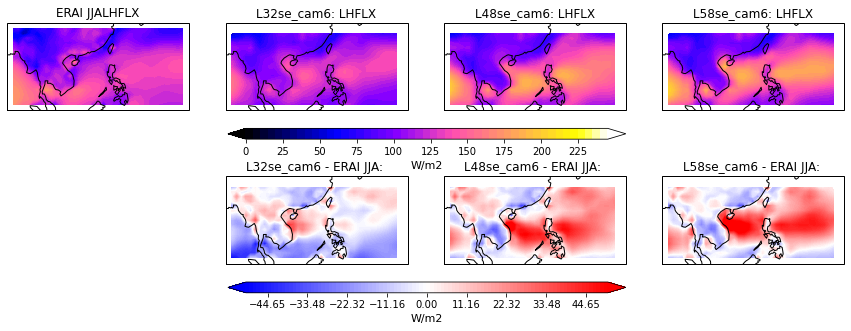

In [21]:
axs = plotBiases_regridded(sel_erai_jja, 'LHFLX', 1,
                           sel_L32, sel_L48, sel_L58, 'LHFLX',
                           'ERAI JJA', 'W/m2')


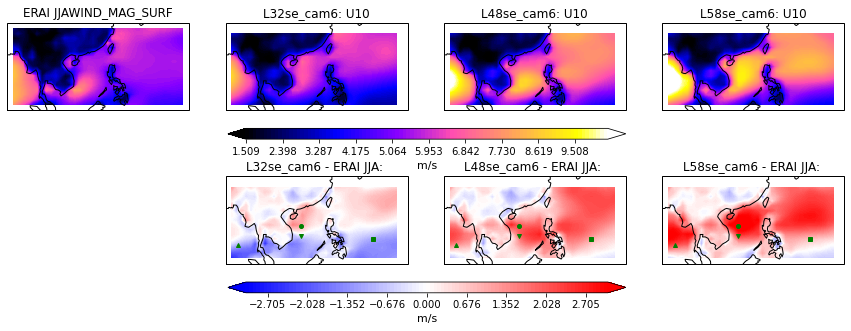

In [153]:
axs = plotBiases_regridded(sel_erai_jja, 'WIND_MAG_SURF', 1,
                           sel_L32, sel_L48, sel_L58, 'U10',
                           'ERAI JJA', 'm/s')


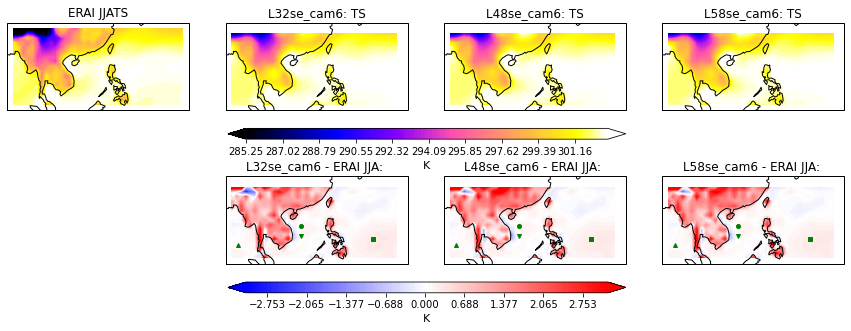

In [173]:
axs = plotBiases_regridded(sel_erai_jja, 'TS', 1,
                           sel_L32, sel_L48, sel_L58, 'TS',
                           'ERAI JJA', 'K')


**Just a few extra maps**

Text(0.5, 1.0, 'L58se_cam6: SWCF+LWCF')

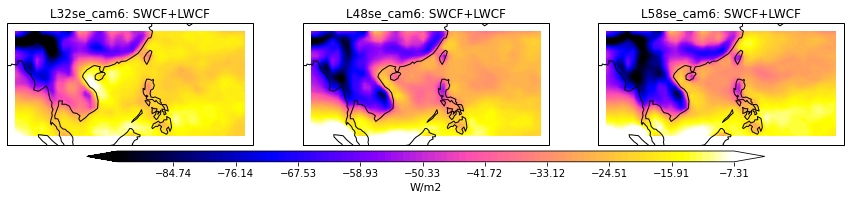

In [28]:

var_selL32 = sel_L32['SWCF'] + sel_L32['LWCF']
var_selL48 = sel_L48['SWCF'] + sel_L48['LWCF']
var_selL58 = sel_L58['SWCF'] + sel_L58['LWCF']

## - - - - - - - - - - - - - - - - - - - - - - - - - -
## Get colorbar limits for raw data and for biases 
maxRawVal = np.nanmax( [np.nanpercentile(var_selL32, 98),
                        np.nanpercentile(var_selL48, 98), 
                        np.nanpercentile(var_selL58, 98)] )
minRawVal = np.nanmin( [np.nanpercentile(var_selL32,  2),
                        np.nanpercentile(var_selL48,  2), 
                        np.nanpercentile(var_selL58,  2)] )
levsMap    = np.arange(minRawVal, maxRawVal, (maxRawVal-minRawVal)/100.0)
# levsMap = np.arange(0,250,5)   # non-flexible optoin; works for LHFLX if want to match plot with gust sims 


## - - - - - - - - - - - - - - - - - - - - - - - - - -
## Make cool plots of raw data 
fig,axs = plt.subplots(1,3, figsize=(15,3), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot observations 
contour_plot = axs[0].contourf(sel_L32.lon.values, sel_L32.lat.values, np.squeeze(var_selL32.values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].set_extent([np.nanmin(sel_L32.lon.values)-2,np.nanmax(sel_L32.lon.values)+2,
                   np.nanmin(sel_L32.lat.values)-2,np.nanmax(sel_L32.lat.values)+2], crs=ccrs.PlateCarree())
axs[0].set_title('L32se_cam6: SWCF+LWCF')

# Plot model data 
contour_plot = axs[1].contourf(sel_L48.lon.values, sel_L48.lat.values, np.squeeze(var_selL48.values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].set_extent([np.nanmin(sel_L48.lon.values)-2,np.nanmax(sel_L48.lon.values)+2,
                   np.nanmin(sel_L48.lat.values)-2,np.nanmax(sel_L48.lat.values)+2], crs=ccrs.PlateCarree())
axs[1].set_title('L48se_cam6: SWCF+LWCF')
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.4, 0.05])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('W/m2',fontsize=11)



contour_plot = axs[2].contourf(sel_L58.lon.values, sel_L58.lat.values, np.squeeze(var_selL58.values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())
axs[2].coastlines()
axs[2].set_extent([np.nanmin(sel_L58.lon.values)-2,np.nanmax(sel_L58.lon.values)+2,
                   np.nanmin(sel_L58.lat.values)-2,np.nanmax(sel_L58.lat.values)+2], crs=ccrs.PlateCarree())
axs[2].set_title('L58se_cam6: SWCF+LWCF')



Text(0.5, 1.0, 'L58se_cam6: CLDLOW')

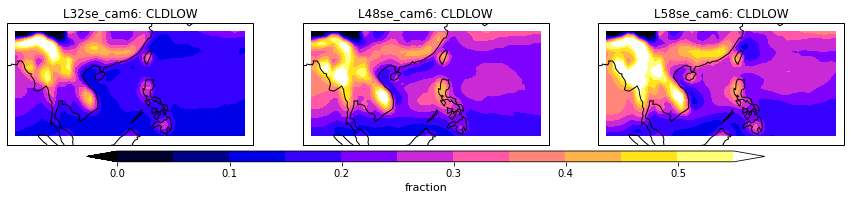

In [32]:

var_selL32 = sel_L32['CLDLOW'] 
var_selL48 = sel_L48['CLDLOW'] 
var_selL58 = sel_L58['CLDLOW'] 

## - - - - - - - - - - - - - - - - - - - - - - - - - -
## Get colorbar limits for raw data and for biases 
maxRawVal = np.nanmax( [np.nanpercentile(var_selL32, 98),
                        np.nanpercentile(var_selL48, 98), 
                        np.nanpercentile(var_selL58, 98)] )
minRawVal = np.nanmin( [np.nanpercentile(var_selL32,  2),
                        np.nanpercentile(var_selL48,  2), 
                        np.nanpercentile(var_selL58,  2)] )
# levsMap    = np.arange(minRawVal, maxRawVal, (maxRawVal-minRawVal)/100.0)
levsMap = np.arange(0,0.6,0.05)   # non-flexible optoin; works for cloud fraction


## - - - - - - - - - - - - - - - - - - - - - - - - - -
## Make cool plots of raw data 
fig,axs = plt.subplots(1,3, figsize=(15,3), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot observations 
contour_plot = axs[0].contourf(sel_L32.lon.values, sel_L32.lat.values, np.squeeze(var_selL32.values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].set_extent([np.nanmin(sel_L32.lon.values)-2,np.nanmax(sel_L32.lon.values)+2,
                   np.nanmin(sel_L32.lat.values)-2,np.nanmax(sel_L32.lat.values)+2], crs=ccrs.PlateCarree())
axs[0].set_title('L32se_cam6: CLDLOW')

# Plot model data 
contour_plot = axs[1].contourf(sel_L48.lon.values, sel_L48.lat.values, np.squeeze(var_selL48.values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].set_extent([np.nanmin(sel_L48.lon.values)-2,np.nanmax(sel_L48.lon.values)+2,
                   np.nanmin(sel_L48.lat.values)-2,np.nanmax(sel_L48.lat.values)+2], crs=ccrs.PlateCarree())
axs[1].set_title('L48se_cam6: CLDLOW')
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.4, 0.05])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('fraction',fontsize=11)



contour_plot = axs[2].contourf(sel_L58.lon.values, sel_L58.lat.values, np.squeeze(var_selL58.values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())
axs[2].coastlines()
axs[2].set_extent([np.nanmin(sel_L58.lon.values)-2,np.nanmax(sel_L58.lon.values)+2,
                   np.nanmin(sel_L58.lat.values)-2,np.nanmax(sel_L58.lat.values)+2], crs=ccrs.PlateCarree())
axs[2].set_title('L58se_cam6: CLDLOW')



**Look into vertical profiles**

In [20]:
## Select these points... 

## Get points that are already averaged in time too
IOpoint_selL32     = sel_L32.sel(lon=92,lat=10, method='nearest')
IOpoint_selL48     = sel_L48.sel(lon=92,lat=10, method='nearest')
IOpoint_selL58     = sel_L58.sel(lon=92,lat=10, method='nearest')

SCSpointTop_selL32 = sel_L32.sel(lon=112,lat=16, method='nearest')
SCSpointTop_selL48 = sel_L48.sel(lon=112,lat=16, method='nearest')
SCSpointTop_selL58 = sel_L58.sel(lon=112,lat=16, method='nearest')

SCSpointBot_selL32 = sel_L32.sel(lon=112,lat=13, method='nearest')
SCSpointBot_selL48 = sel_L48.sel(lon=112,lat=13, method='nearest')
SCSpointBot_selL58 = sel_L58.sel(lon=112,lat=13, method='nearest')

WPpoint_selL32     = sel_L32.sel(lon=135,lat=12, method='nearest')
WPpoint_selL48     = sel_L48.sel(lon=135,lat=12, method='nearest')
WPpoint_selL58     = sel_L58.sel(lon=135,lat=12, method='nearest')



In [113]:
IOpoint_erai     = sel_erai_jja.sel(lon=92,lat=10, method='nearest')
SCSpointTop_erai = sel_erai_jja.sel(lon=112,lat=16, method='nearest')
SCSpointBot_erai = sel_erai_jja.sel(lon=112,lat=13, method='nearest')
WPpoint_erai     = sel_erai_jja.sel(lon=135,lat=12, method='nearest')


**Vertical profiles?**

In [104]:
def plotProfiles(L32ds, L48ds, L58ds, dsVarName,
                 obsDS, obsVarName, obsMult, 
                 xMin, xMax, yBot, yTop, 
                 titleString):
    
    fig,axs = plt.subplots(1,1,figsize=(6,5))
    
    axs.plot(L32ds[dsVarName].values, L32ds.lev.values, color='mediumblue', label='L32')
    axs.plot(L48ds[dsVarName].values, L48ds.lev.values, color='dodgerblue', label='L48')
    axs.plot(L58ds[dsVarName].values, L58ds.lev.values, color='turquoise', label='L58')
    
    axs.plot(np.squeeze(obsDS[obsVarName].values)*obsMult, obsDS.lev.values,'k--', markersize=5, alpha=0.7, label='ERAI')

    axs.legend()
    axs.invert_yaxis()

    axs.set_xlabel(L32_h1[dsVarName].units)
    axs.set_ylabel(L32_h1['lev'].units)
    axs.set_title(dsVarName+': '+titleString)

    axs.set_ylim([yBot, yTop])
    axs.set_xlim([xMin, xMax])

    
    return

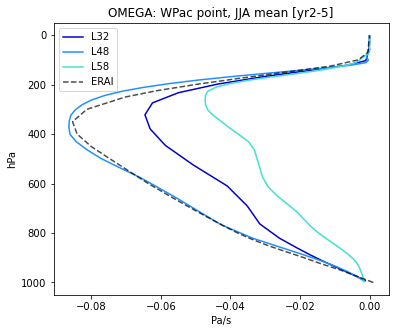

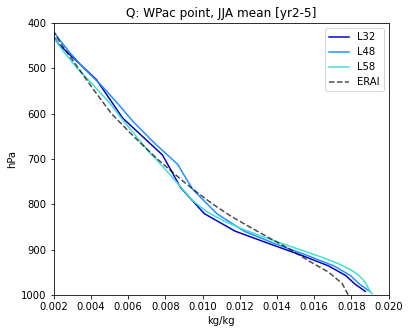

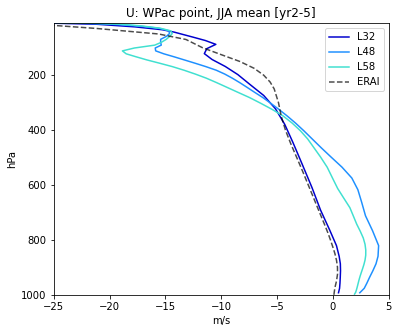

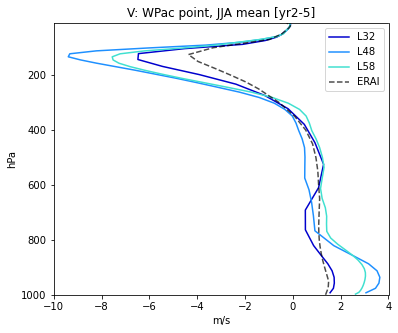

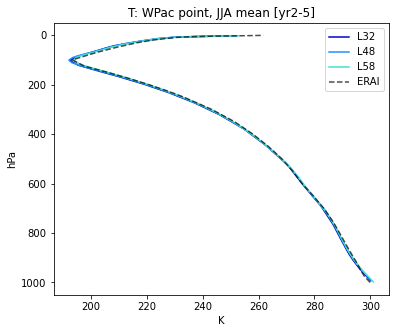

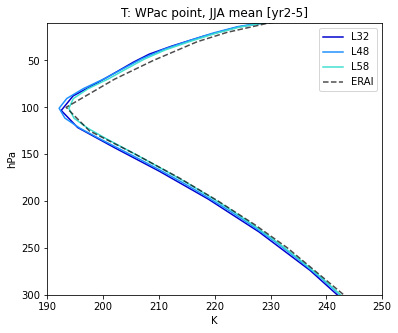

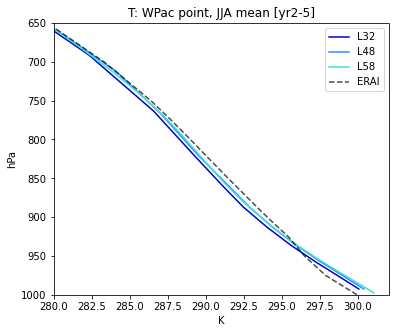

In [112]:

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'OMEGA',
             WPpoint_erai, 'OMEGA', 100.0/86400.0, 
             None, None, None, None, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'Q',
             WPpoint_erai, 'SHUM', 1e-3, 
             0.002, 0.02, 1000, 400, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'U',
             WPpoint_erai, 'U', 1, 
             -25, 5, 1000, 10, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'V',
             WPpoint_erai, 'V', 1, 
             -10, 4, 1000, 10, 
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'T',
             WPpoint_erai, 'T', 1, 
             None, None, None, None,
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'T',
             WPpoint_erai, 'T', 1, 
             190, 250, 300, 10,
             'WPac point, JJA mean [yr2-5]')

plotProfiles(WPpoint_selL32, WPpoint_selL48, WPpoint_selL58, 'T',
             WPpoint_erai, 'T', 1, 
             280, 302, 1000, 650,
             'WPac point, JJA mean [yr2-5]')



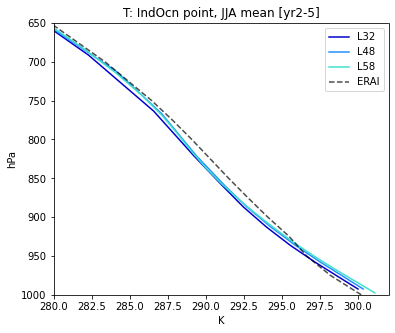

In [127]:

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'OMEGA',
#              IOpoint_erai, 'OMEGA', 100.0/86400.0, 
#              None, None, None, None, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'Q',
#              IOpoint_erai, 'SHUM', 1e-3, 
#              0.002, 0.02, 1000, 400, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'U',
#              IOpoint_erai, 'U', 1, 
#              -38, 15, 1000, 10, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'V',
#              IOpoint_erai, 'V', 1, 
#              -10, 8, 1000, 10, 
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'T',
#              IOpoint_erai, 'T', 1, 
#              None, None, None, None,
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'T',
#              IOpoint_erai, 'T', 1, 
#              190, 245, 300, 10,
#              'IndOcn point, JJA mean [yr2-5]')

# plotProfiles(IOpoint_selL32, IOpoint_selL48, IOpoint_selL58, 'T',
#              IOpoint_erai, 'T', 1, 
#              280, 302, 1000, 650,
#              'IndOcn point, JJA mean [yr2-5]')



In [140]:
# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'OMEGA',
#              SCSpointTop_erai, 'OMEGA', 100.0/86400.0, 
#              None, None, None, None, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'Q',
#              SCSpointTop_erai, 'SHUM', 1e-3, 
#              0.002, 0.02, 1000, 400, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'U',
#              SCSpointTop_erai, 'U', 1, 
#              -28, 10, 1000, 10, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'V',
#              SCSpointTop_erai, 'V', 1, 
#              -8, 10, 1000, 10, 
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'T',
#              SCSpointTop_erai, 'T', 1, 
#              None, None, None, None,
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'T',
#              SCSpointTop_erai, 'T', 1, 
#              190, 245, 300, 10,
#              'SCS point (top), JJA mean [yr2-5]')

# plotProfiles(SCSpointTop_selL32, SCSpointTop_selL48, SCSpointTop_selL58, 'T',
#              SCSpointTop_erai, 'T', 1, 
#              280, 302, 1000, 650,
#              'SCS point (top), JJA mean [yr2-5]')



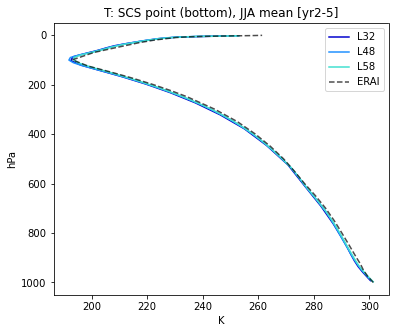

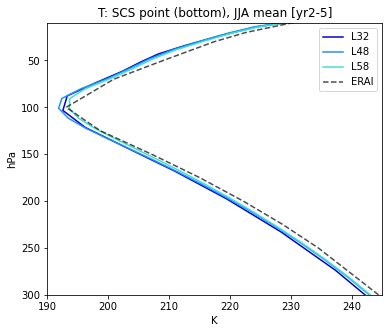

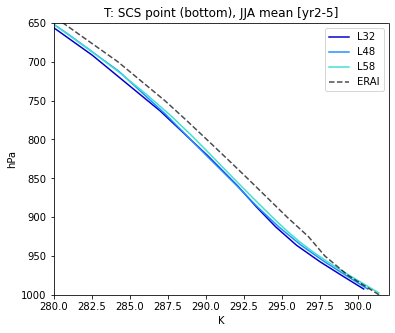

In [151]:
# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'OMEGA',
#              SCSpointBot_erai, 'OMEGA', 100.0/86400.0, 
#              None, None, None, None, 
#              'SCS point (bottom), JJA mean [yr2-5]')

# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'Q',
#              SCSpointTop_erai, 'SHUM', 1e-3, 
#              0.002, 0.02, 1000, 400, 
#              'SCS point (bottom), JJA mean [yr2-5]')

# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'U',
#              SCSpointTop_erai, 'U', 1, 
#              -28, 12, 1000, 10, 
#              'SCS point (bottom), JJA mean [yr2-5]')

# plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'V',
#              SCSpointTop_erai, 'V', 1, 
#              -7, 9, 1000, 10, 
#              'SCS point (bottom), JJA mean [yr2-5]')

plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'T',
             SCSpointTop_erai, 'T', 1, 
             None, None, None, None,
             'SCS point (bottom), JJA mean [yr2-5]')

plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'T',
             SCSpointTop_erai, 'T', 1, 
             190, 245, 300, 10,
             'SCS point (bottom), JJA mean [yr2-5]')

plotProfiles(SCSpointBot_selL32, SCSpointBot_selL48, SCSpointBot_selL58, 'T',
             SCSpointTop_erai, 'T', 1, 
             280, 302, 1000, 650,
             'SCS point (bottom), JJA mean [yr2-5]')



**Regional PDF-type analysis?**

In [18]:
## Handle regridding the CAM data to obs grid
# Get obs grid 
obsGrid = sel_erai_jja['TS'].isel(time=0).squeeze()

# Now regrid the data
regrid_ds32    = regrid_data(sel_L32, obsGrid, method=1)
regrid_ds48    = regrid_data(sel_L48, obsGrid, method=1)
regrid_ds58    = regrid_data(sel_L58, obsGrid, method=1)
regrid_mask    = regrid_data(sel_maskDS, obsGrid, method=1) 


In [19]:
## Interpolate to constant pressure levels? 

def interpolateToPressure_v2(DS, varName, pressGoals):
    
    p0mb = 100000.0/100 # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)
    hybm = np.squeeze(DS.hybm.values)
    hyai = np.squeeze(DS.hyai.values)
    hybi = np.squeeze(DS.hybi.values)

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[0]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,False)
    elif np.shape(DS[varName].values)[0]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,False)

    saveOut = varInterp
    
    return saveOut


In [20]:
varsToInterp = ['T','Q','U','V','OMEGA']
pNew         = [900,850,800,750,700,650,600,550,500,450,400,350,300,250,200]

for iVar in range(len(varsToInterp)):
    interpVar_32 = interpolateToPressure_v2(regrid_ds32, varsToInterp[iVar], pNew)
    interpVar_48 = interpolateToPressure_v2(regrid_ds48, varsToInterp[iVar], pNew)
    interpVar_58 = interpolateToPressure_v2(regrid_ds58, varsToInterp[iVar], pNew)
    
    regrid_ds32[varsToInterp[iVar]+'_interp']  = (('levInterp','lat','lon'), interpVar_32)
    regrid_ds48[varsToInterp[iVar]+'_interp']  = (('levInterp','lat','lon'), interpVar_48)
    regrid_ds58[varsToInterp[iVar]+'_interp']  = (('levInterp','lat','lon'), interpVar_58)
    
    print('Done with variable %i of %i' % (iVar+1, len(varsToInterp) ) )
    

Done with variable 1 of 5
Done with variable 2 of 5
Done with variable 3 of 5
Done with variable 4 of 5
Done with variable 5 of 5


In [21]:
regrid_ds32 = regrid_ds32.assign_coords({"levInterp": pNew})
regrid_ds48 = regrid_ds48.assign_coords({"levInterp": pNew})
regrid_ds58 = regrid_ds58.assign_coords({"levInterp": pNew})


In [22]:
LHbias_L32    = regrid_ds32.LHFLX.values -  sel_erai_jja.isel(time=0).LHFLX.values  ## W/m2
U10bias_L32   = regrid_ds32.U10.values -  sel_erai_jja.isel(time=0).WIND_MAG_SURF.values  ## m/s
PRECTbias_L32 = (regrid_ds32.PRECT.values*86400*1000) -  sel_erai_jja.isel(time=0).PRECT.values ## mm/d


LHbias_L48    = regrid_ds48.LHFLX.values -  sel_erai_jja.isel(time=0).LHFLX.values  ## W/m2
U10bias_L48   = regrid_ds48.U10.values -  sel_erai_jja.isel(time=0).WIND_MAG_SURF.values  ## m/s
PRECTbias_L48 = (regrid_ds48.PRECT.values*86400*1000) -  sel_erai_jja.isel(time=0).PRECT.values ## mm/d


LHbias_L58    = regrid_ds58.LHFLX.values -  sel_erai_jja.isel(time=0).LHFLX.values  ## W/m2
U10bias_L58   = regrid_ds58.U10.values -  sel_erai_jja.isel(time=0).WIND_MAG_SURF.values  ## m/s
PRECTbias_L58 = (regrid_ds58.PRECT.values*86400*1000) -  sel_erai_jja.isel(time=0).PRECT.values ## mm/d



(64.6502523078918, 225.4369678370158)

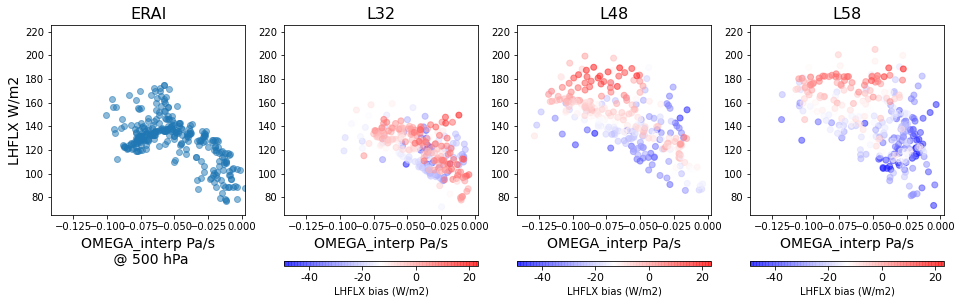

In [39]:
selLev  = 500
xVar    = 'OMEGA_interp'
xUnitsVar = 'OMEGA'
yVar    = 'LHFLX'

obsVarX = 'OMEGA'
obsX_mult = 100.0/86400.0
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units+'\n @ '+str(selLev)+' hPa', fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(2.620782108306885, 12.769648063182832)

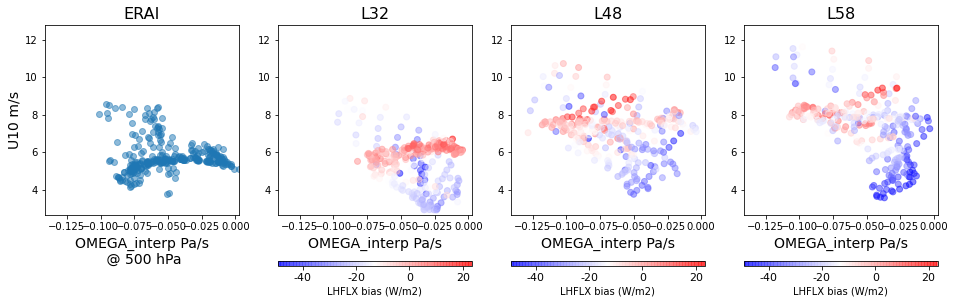

In [40]:
selLev  = 500
xVar    = 'OMEGA_interp'
xUnitsVar = 'OMEGA'
yVar    = 'U10'

obsVarX = 'OMEGA'
obsX_mult = 100.0/86400.0
obsVarY   = 'WIND_MAG_SURF'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units+'\n @ '+str(selLev)+' hPa', fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(64.6502523078918, 225.4369678370158)

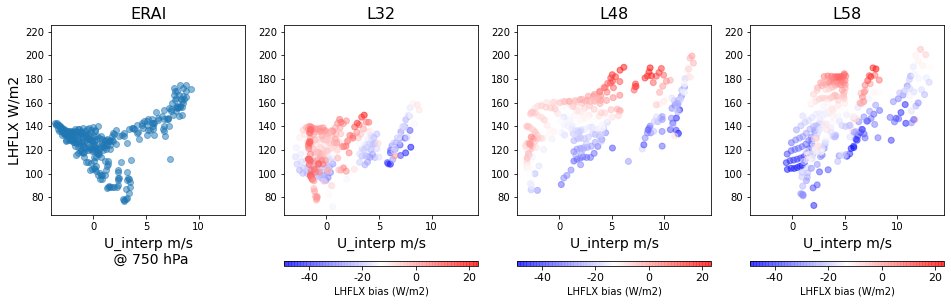

In [92]:
selLev  = 750
xVar    = 'U_interp'
xUnitsVar = 'U'
yVar    = 'LHFLX'

obsVarX = 'U'
obsX_mult = 1
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units+'\n @ '+str(selLev)+' hPa', fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(71.11527753868099, 206.99212501398722)

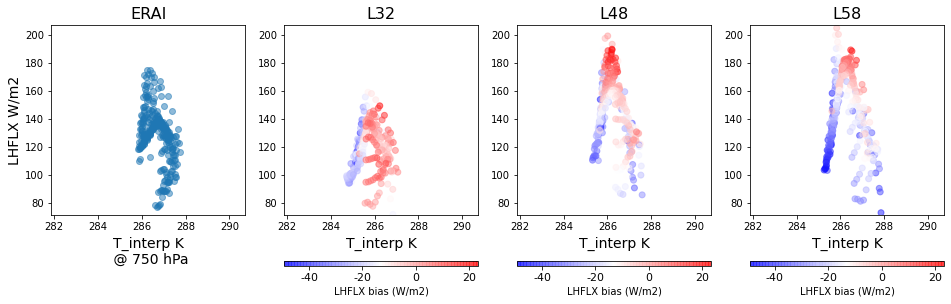

In [98]:
selLev  = 750
xVar    = 'T_interp'
xUnitsVar = 'T'
yVar    = 'LHFLX'

obsVarX = 'T'
obsX_mult = 1
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units+'\n @ '+str(selLev)+' hPa', fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])
axs[1].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])
axs[2].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])
axs[3].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])

axs[0].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])
axs[1].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])
axs[2].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])
axs[3].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])


(71.11527753868099, 206.99212501398722)

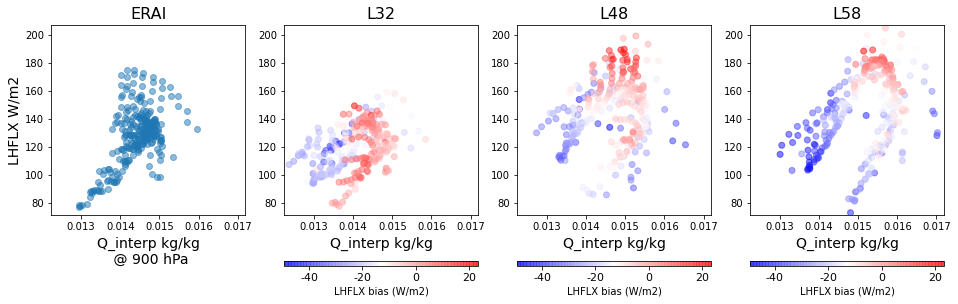

In [112]:
selLev  = 900
xVar    = 'Q_interp'
xUnitsVar = 'Q'
yVar    = 'LHFLX'

obsVarX = 'SHUM'
obsX_mult = 1.0/1000.0
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units+'\n @ '+str(selLev)+' hPa', fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0).sel(lev=selLev)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58.sel(levInterp=selLev)[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])
axs[1].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])
axs[2].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])
axs[3].set_xlim([minX - np.abs(minX*0.01),  maxX + np.abs(maxX*0.01)])

axs[0].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])
axs[1].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])
axs[2].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])
axs[3].set_ylim([minY - np.abs(minY*0.01),  maxY + np.abs(maxY*0.01)])


**Stuff without a level**

(2.620782108306885, 12.769648063182832)

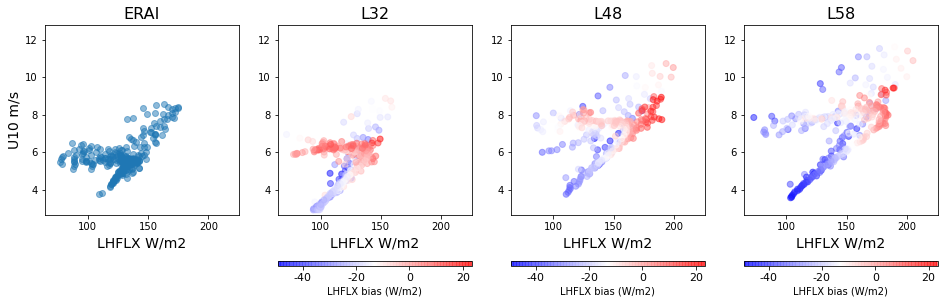

In [36]:
selLev  = None
xVar    = 'LHFLX'
xUnitsVar = 'LHFLX'
yVar    = 'U10'

obsVarX = 'LHFLX'
obsX_mult = 1
obsVarY   = 'WIND_MAG_SURF'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(0.45428831577301027, 1.0814011618494987)

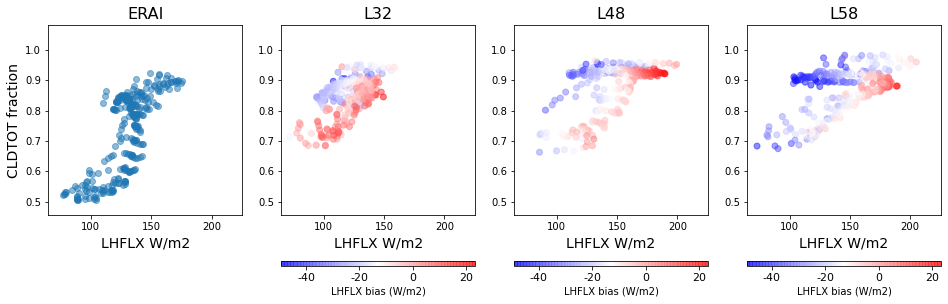

In [35]:
selLev  = None
xVar    = 'LHFLX'
xUnitsVar = 'LHFLX'
yVar    = 'CLDTOT'

obsVarX = 'LHFLX'
obsX_mult = 1
obsVarY   = 'CLDTOT'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

## Plot obs?
axs[0].scatter((sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
            (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
               alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([(sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(-152.0558982086181, -36.768563547134406)

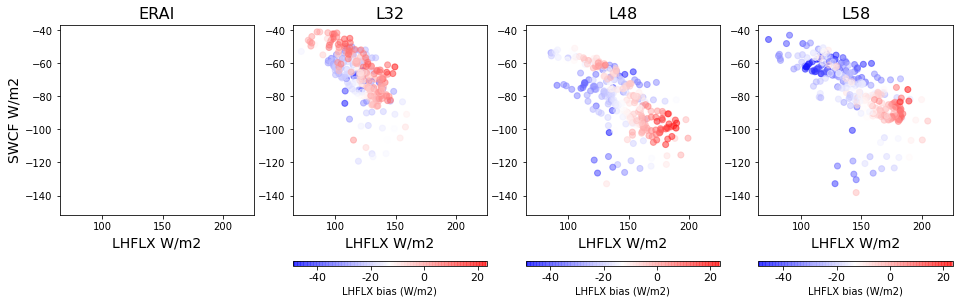

In [34]:
selLev  = None
xVar    = 'LHFLX'
xUnitsVar = 'LHFLX'
yVar    = 'SWCF'

obsVarX = 'CLDTOT'
obsX_mult = 1
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

# ## Plot obs?
# axs[0].scatter((sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
#             (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
#                alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([
                  # (sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([
                 # (sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([
                  # (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([
                  # (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(21.606097134590147, 88.05474906921386)

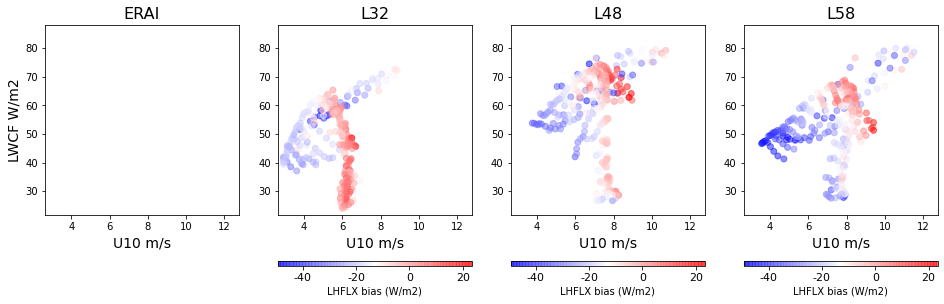

In [33]:
selLev  = None
xVar    = 'LHFLX'
xUnitsVar = 'LHFLX'
yVar    = 'LWCF'

obsVarX = 'CLDTOT'
obsX_mult = 1
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

# ## Plot obs?
# axs[0].scatter((sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
#             (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
#                alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([
                  # (sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([
                 # (sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([
                  # (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([
                  # (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


(-152.0558982086181, -36.768563547134406)

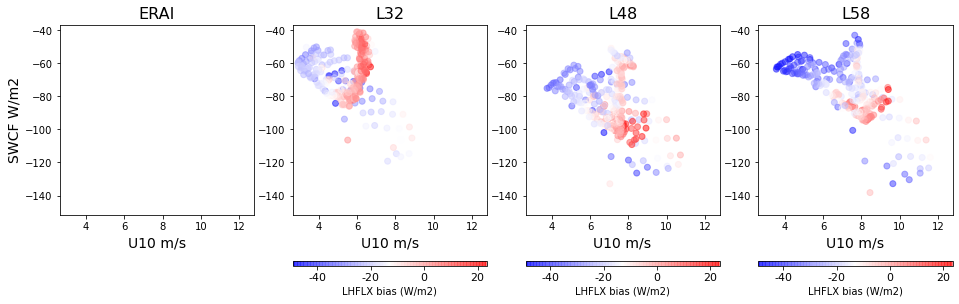

In [38]:
selLev  = None
xVar    = 'U10'
xUnitsVar = 'U10'
yVar    = 'SWCF'

obsVarX = 'CLDTOT'
obsX_mult = 1
obsVarY   = 'LHFLX'

fig,axs = plt.subplots(1,4, figsize=(16,3.5) )
axs     = axs.ravel()

# ## Plot obs?
# axs[0].scatter((sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
#             (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
#                alpha=0.5)


## Plot JJA-mean CAM version of this
cplt = axs[1].scatter((regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
            (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
             c=(LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[2].scatter((regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
            (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
            c=(LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[3].scatter((regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
            (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]), 
             c=(LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]),
               cmap='bwr',
               alpha = 0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.02])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 


axs[0].set_title('ERAI', fontsize=16)
axs[1].set_title('L32', fontsize=16)
axs[2].set_title('L48', fontsize=16)
axs[3].set_title('L58', fontsize=16)

axs[0].set_ylabel(yVar+' '+L32_h1[yVar].units, fontsize=14)
axs[0].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[1].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[2].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)
axs[3].set_xlabel(xVar+' '+L32_h1[xUnitsVar].units, fontsize=14)

maxX = np.nanmax([
                  # (sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minX = np.nanmin([
                 # (sel_erai_jja.isel(time=0)[obsVarX].values*(regrid_mask['oceanMask'].values)*obsX_mult).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])


maxY = np.nanmax([
                  # (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

minY = np.nanmin([
                  # (sel_erai_jja.isel(time=0)[obsVarY].values*(regrid_mask['oceanMask'].values)).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]),
                  (regrid_ds32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds32.lat.values)*len(regrid_ds32.lon.values),1]), 
                  (regrid_ds48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds48.lat.values)*len(regrid_ds48.lon.values),1]), 
                  (regrid_ds58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(regrid_ds58.lat.values)*len(regrid_ds58.lon.values),1]) ])

axs[0].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[1].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[2].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])
axs[3].set_xlim([minX - np.abs(minX*0.1),  maxX + np.abs(maxX*0.1)])

axs[0].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[1].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[2].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])
axs[3].set_ylim([minY - np.abs(minY*0.1),  maxY + np.abs(maxY*0.1)])


**Stuff with an average layer**

In [41]:
ilevsUpper = np.where((regrid_ds32.levInterp.values<=400) & (regrid_ds32.levInterp.values>=200) )[0]
ilevsMiddle = np.where((regrid_ds32.levInterp.values<=600) & (regrid_ds32.levInterp.values>=400) )[0]
ilevsLower = np.where((regrid_ds32.levInterp.values<=800) & (regrid_ds32.levInterp.values>=600) )[0]

upLev_L32  = regrid_ds32.isel(levInterp=ilevsUpper).mean(dim='levInterp')
lowLev_L32 = regrid_ds32.isel(levInterp=ilevsLower).mean(dim='levInterp')
midLev_L32 = regrid_ds32.isel(levInterp=ilevsMiddle).mean(dim='levInterp')

upLev_L48  = regrid_ds48.isel(levInterp=ilevsUpper).mean(dim='levInterp')
lowLev_L48 = regrid_ds48.isel(levInterp=ilevsLower).mean(dim='levInterp')
midLev_L48 = regrid_ds48.isel(levInterp=ilevsMiddle).mean(dim='levInterp')

upLev_L58  = regrid_ds58.isel(levInterp=ilevsUpper).mean(dim='levInterp')
lowLev_L58 = regrid_ds58.isel(levInterp=ilevsLower).mean(dim='levInterp')
midLev_L58 = regrid_ds58.isel(levInterp=ilevsMiddle).mean(dim='levInterp')



(-0.15, 0.01)

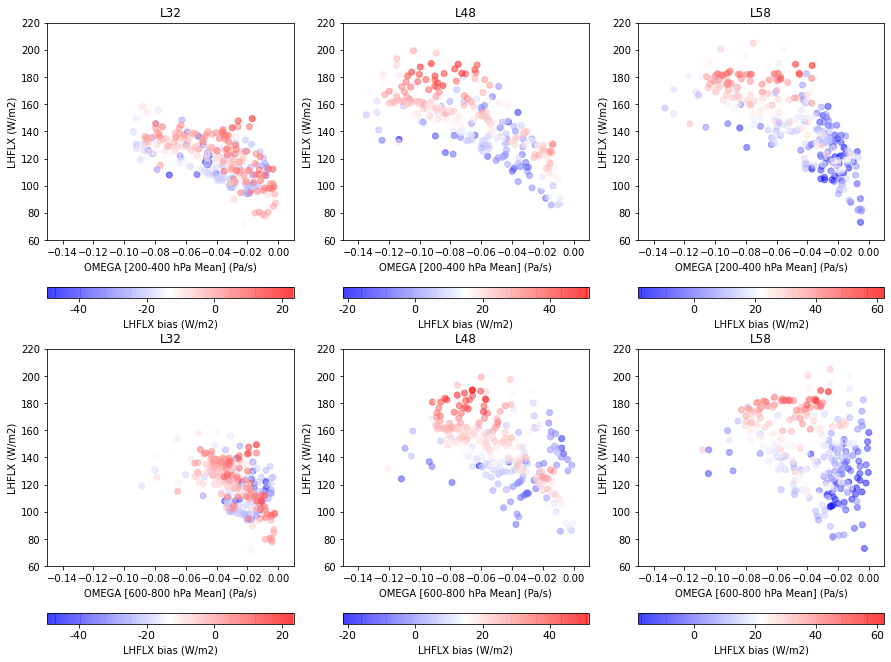

In [145]:
fig,axs = plt.subplots(2,3, figsize=(15,10) )
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

## Upper levels 

cplt = axs[0].scatter((upLev_L32.OMEGA_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
               (upLev_L32.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[0].set_title('L32')
axs[0].set_ylabel('LHFLX (W/m2)')
axs[0].set_xlabel('OMEGA [200-400 hPa Mean] (Pa/s)')


cplt = axs[1].scatter((upLev_L48.OMEGA_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
               (upLev_L48.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[1].set_title('L48')
axs[1].set_ylabel('LHFLX (W/m2)')
axs[1].set_xlabel('OMEGA [200-400 hPa Mean] (Pa/s)')


cplt = axs[2].scatter((upLev_L58.OMEGA_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
               (upLev_L58.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[2].set_title('L58')
axs[2].set_ylabel('LHFLX (W/m2)')
axs[2].set_xlabel('OMEGA [200-400 hPa Mean] (Pa/s)')

axs[0].set_ylim([60, 220])
axs[1].set_ylim([60, 220])
axs[2].set_ylim([60, 220])

axs[0].set_xlim([-0.15, 0.01])
axs[1].set_xlim([-0.15, 0.01])
axs[2].set_xlim([-0.15, 0.01])



## Lower levels 

cplt = axs[3].scatter((lowLev_L32.OMEGA_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
               (lowLev_L32.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[3].set_title('L32')
axs[3].set_ylabel('LHFLX (W/m2)')
axs[3].set_xlabel('OMEGA [600-800 hPa Mean] (Pa/s)')


cplt = axs[4].scatter((lowLev_L48.OMEGA_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
               (lowLev_L48.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[4].set_title('L48')
axs[4].set_ylabel('LHFLX (W/m2)')
axs[4].set_xlabel('OMEGA [600-800 hPa Mean] (Pa/s)')


cplt = axs[5].scatter((lowLev_L58.OMEGA_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
               (lowLev_L58.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[5].set_title('L58')
axs[5].set_ylabel('LHFLX (W/m2)')
axs[5].set_xlabel('OMEGA [600-800 hPa Mean] (Pa/s)')

axs[3].set_ylim([60, 220])
axs[4].set_ylim([60, 220])
axs[5].set_ylim([60, 220])

axs[3].set_xlim([-0.15, 0.01])
axs[4].set_xlim([-0.15, 0.01])
axs[5].set_xlim([-0.15, 0.01])



(-4.0, 14.0)

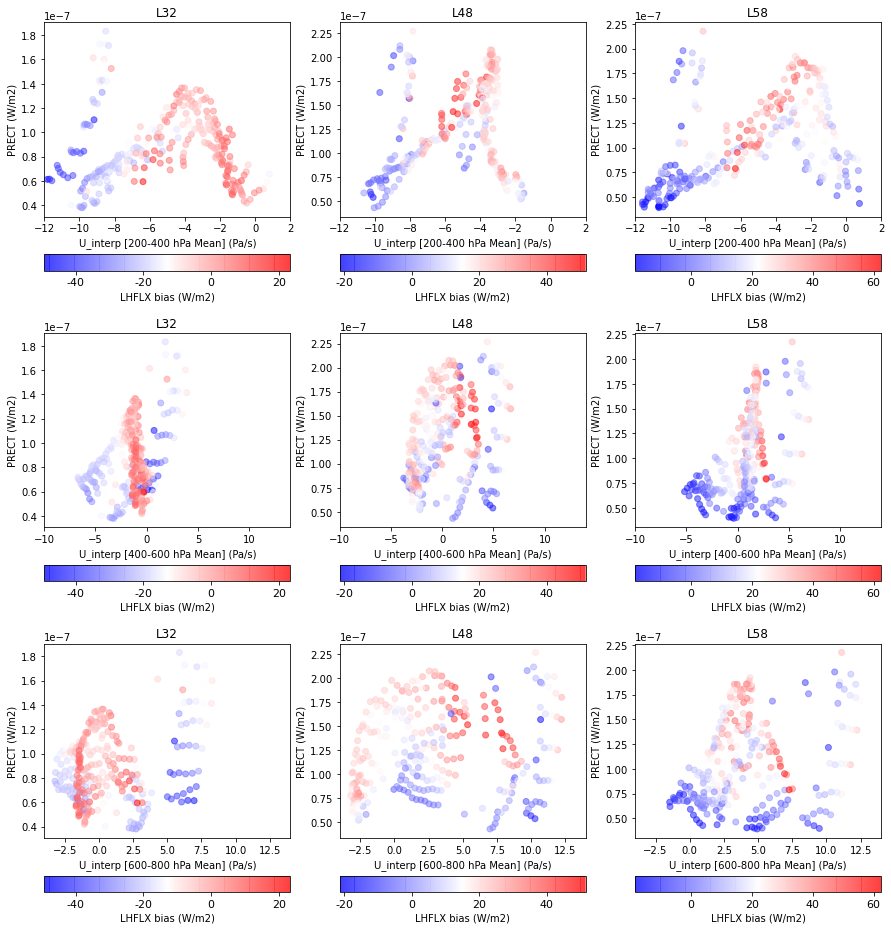

In [62]:
fig,axs = plt.subplots(3,3, figsize=(15,15) )
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.6)


xVar = 'U_interp'
yVar = 'PRECT'  

## Upper levels 

cplt = axs[0].scatter((upLev_L32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
                      (upLev_L32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[0].set_title('L32')
axs[0].set_ylabel(yVar+' (W/m2)')
axs[0].set_xlabel(xVar+' [200-400 hPa Mean] (Pa/s)')


cplt = axs[1].scatter((upLev_L48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
                      (upLev_L48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[1].set_title('L48')
axs[1].set_ylabel(yVar+' (W/m2)')
axs[1].set_xlabel(xVar+' [200-400 hPa Mean] (Pa/s)')


cplt = axs[2].scatter((upLev_L58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
                      (upLev_L58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[2].set_title('L58')
axs[2].set_ylabel(yVar+' (W/m2)')
axs[2].set_xlabel(xVar+' [200-400 hPa Mean] (Pa/s)')

# axs[0].set_ylim([60, 220])
# axs[1].set_ylim([60, 220])
# axs[2].set_ylim([60, 220])

axs[0].set_xlim([-12, 2])
axs[1].set_xlim([-12, 2])
axs[2].set_xlim([-12, 2])




## Middle levels 

cplt = axs[3].scatter((midLev_L32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L32.lat.values)*len(midLev_L32.lon.values),1]),
                      (midLev_L32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L32.lat.values)*len(midLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(midLev_L32.lat.values)*len(midLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[3].set_title('L32')
axs[3].set_ylabel(yVar+' (W/m2)')
axs[3].set_xlabel(xVar+' [400-600 hPa Mean] (Pa/s)')


cplt = axs[4].scatter((midLev_L48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L48.lat.values)*len(midLev_L48.lon.values),1]),
                      (midLev_L48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L48.lat.values)*len(midLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(midLev_L48.lat.values)*len(midLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[4].set_title('L48')
axs[4].set_ylabel(yVar+' (W/m2)')
axs[4].set_xlabel(xVar+' [400-600 hPa Mean] (Pa/s)')


cplt = axs[5].scatter((midLev_L58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L58.lat.values)*len(midLev_L58.lon.values),1]),
                      (midLev_L58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L58.lat.values)*len(midLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(midLev_L58.lat.values)*len(midLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[5].set_title('L58')
axs[5].set_ylabel(yVar+' (W/m2)')
axs[5].set_xlabel(xVar+' [400-600 hPa Mean] (Pa/s)')

# axs[3].set_ylim([60, 220])
# axs[4].set_ylim([60, 220])
# axs[5].set_ylim([60, 220])

axs[3].set_xlim([-10, 14])
axs[4].set_xlim([-10, 14])
axs[5].set_xlim([-10, 14])






## Lower levels 

cplt = axs[6].scatter((lowLev_L32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
                      (lowLev_L32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[6].set_title('L32')
axs[6].set_ylabel(yVar+' (W/m2)')
axs[6].set_xlabel(xVar+' [600-800 hPa Mean] (Pa/s)')


cplt = axs[7].scatter((lowLev_L48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
                      (lowLev_L48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[7].set_title('L48')
axs[7].set_ylabel(yVar+' (W/m2)')
axs[7].set_xlabel(xVar+' [600-800 hPa Mean] (Pa/s)')


cplt = axs[8].scatter((lowLev_L58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
                      (lowLev_L58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[8].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[8].set_title('L58')
axs[8].set_ylabel(yVar+' (W/m2)')
axs[8].set_xlabel(xVar+' [600-800 hPa Mean] (Pa/s)')

# axs[6].set_ylim([60, 220])
# axs[7].set_ylim([60, 220])
# axs[8].set_ylim([60, 220])

axs[6].set_xlim([-4, 14])
axs[7].set_xlim([-4, 14])
axs[8].set_xlim([-4, 14])



(-0.15, 0.01)

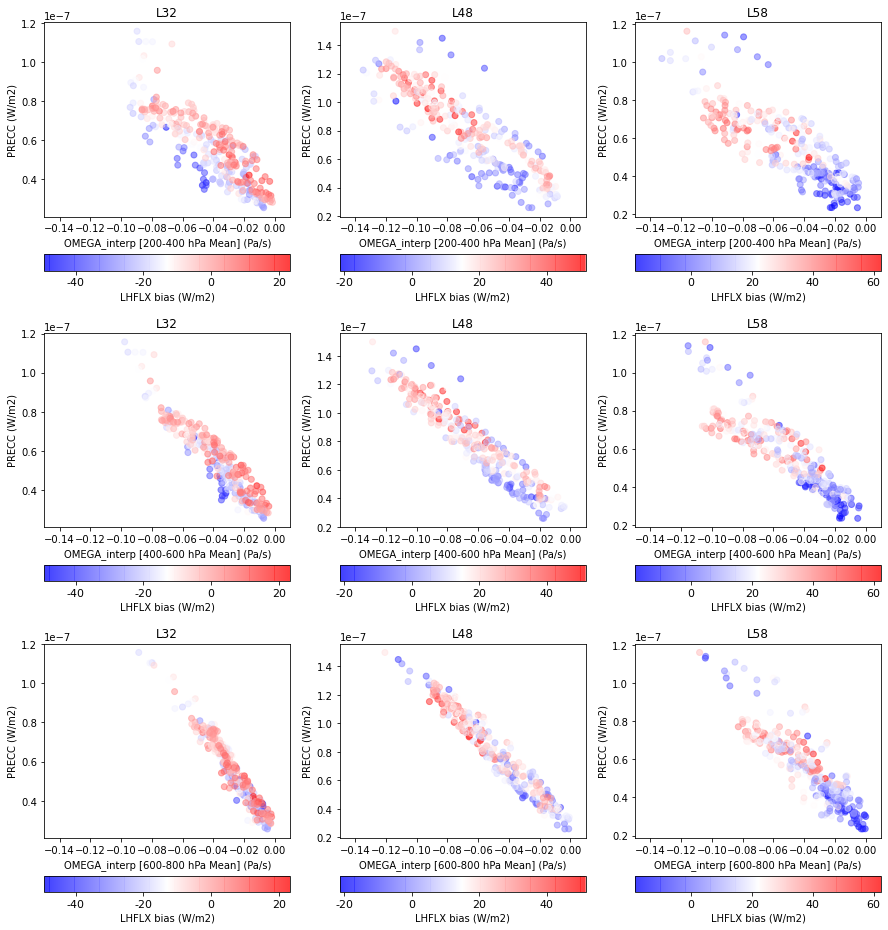

In [58]:
fig,axs = plt.subplots(3,3, figsize=(15,15) )
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.6)


xVar = 'OMEGA_interp'
yVar = 'PRECC'  

## Upper levels 

cplt = axs[0].scatter((upLev_L32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
                      (upLev_L32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[0].set_title('L32')
axs[0].set_ylabel(yVar+' (W/m2)')
axs[0].set_xlabel(xVar+' [200-400 hPa Mean] (Pa/s)')


cplt = axs[1].scatter((upLev_L48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
                      (upLev_L48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[1].set_title('L48')
axs[1].set_ylabel(yVar+' (W/m2)')
axs[1].set_xlabel(xVar+' [200-400 hPa Mean] (Pa/s)')


cplt = axs[2].scatter((upLev_L58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
                      (upLev_L58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[2].set_title('L58')
axs[2].set_ylabel(yVar+' (W/m2)')
axs[2].set_xlabel(xVar+' [200-400 hPa Mean] (Pa/s)')

# axs[0].set_ylim([60, 220])
# axs[1].set_ylim([60, 220])
# axs[2].set_ylim([60, 220])

axs[0].set_xlim([-0.15, 0.01])
axs[1].set_xlim([-0.15, 0.01])
axs[2].set_xlim([-0.15, 0.01])




## Middle levels 

cplt = axs[3].scatter((midLev_L32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L32.lat.values)*len(midLev_L32.lon.values),1]),
                      (midLev_L32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L32.lat.values)*len(midLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(midLev_L32.lat.values)*len(midLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[3].set_title('L32')
axs[3].set_ylabel(yVar+' (W/m2)')
axs[3].set_xlabel(xVar+' [400-600 hPa Mean] (Pa/s)')


cplt = axs[4].scatter((midLev_L48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L48.lat.values)*len(midLev_L48.lon.values),1]),
                      (midLev_L48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L48.lat.values)*len(midLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(midLev_L48.lat.values)*len(midLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[4].set_title('L48')
axs[4].set_ylabel(yVar+' (W/m2)')
axs[4].set_xlabel(xVar+' [400-600 hPa Mean] (Pa/s)')


cplt = axs[5].scatter((midLev_L58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L58.lat.values)*len(midLev_L58.lon.values),1]),
                      (midLev_L58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(midLev_L58.lat.values)*len(midLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(midLev_L58.lat.values)*len(midLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[5].set_title('L58')
axs[5].set_ylabel(yVar+' (W/m2)')
axs[5].set_xlabel(xVar+' [400-600 hPa Mean] (Pa/s)')

# axs[3].set_ylim([60, 220])
# axs[4].set_ylim([60, 220])
# axs[5].set_ylim([60, 220])

axs[3].set_xlim([-0.15, 0.01])
axs[4].set_xlim([-0.15, 0.01])
axs[5].set_xlim([-0.15, 0.01])






## Lower levels 

cplt = axs[6].scatter((lowLev_L32[xVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
                      (lowLev_L32[yVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[6].set_title('L32')
axs[6].set_ylabel(yVar+' (W/m2)')
axs[6].set_xlabel(xVar+' [600-800 hPa Mean] (Pa/s)')


cplt = axs[7].scatter((lowLev_L48[xVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
                      (lowLev_L48[yVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[7].set_title('L48')
axs[7].set_ylabel(yVar+' (W/m2)')
axs[7].set_xlabel(xVar+' [600-800 hPa Mean] (Pa/s)')


cplt = axs[8].scatter((lowLev_L58[xVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
                      (lowLev_L58[yVar].values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[8].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[8].set_title('L58')
axs[8].set_ylabel(yVar+' (W/m2)')
axs[8].set_xlabel(xVar+' [600-800 hPa Mean] (Pa/s)')

# axs[6].set_ylim([60, 220])
# axs[7].set_ylim([60, 220])
# axs[8].set_ylim([60, 220])

axs[6].set_xlim([-0.15, 0.01])
axs[7].set_xlim([-0.15, 0.01])
axs[8].set_xlim([-0.15, 0.01])


(-4.0, 14.0)

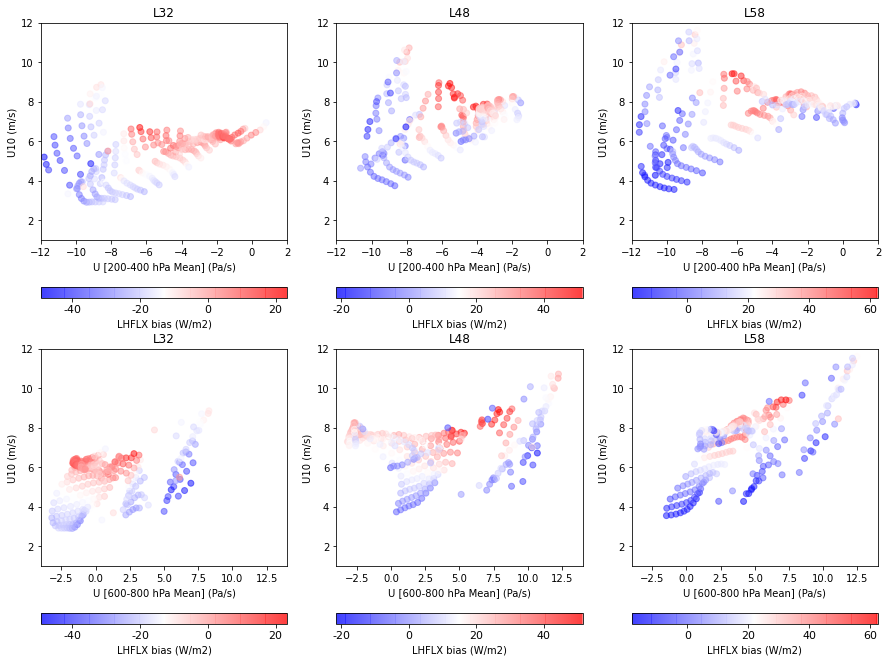

In [151]:
fig,axs = plt.subplots(2,3, figsize=(15,10) )
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

## Upper levels 

cplt = axs[0].scatter((upLev_L32.U_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
               (upLev_L32.U10.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[0].set_title('L32')
axs[0].set_ylabel('U10 (m/s)')
axs[0].set_xlabel('U [200-400 hPa Mean] (Pa/s)')


cplt = axs[1].scatter((upLev_L48.U_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
               (upLev_L48.U10.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[1].set_title('L48')
axs[1].set_ylabel('U10 (m/s)')
axs[1].set_xlabel('U [200-400 hPa Mean] (Pa/s)')


cplt = axs[2].scatter((upLev_L58.U_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
               (upLev_L58.U10.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[2].set_title('L58')
axs[2].set_ylabel('U10 (m/s)')
axs[2].set_xlabel('U [200-400 hPa Mean] (Pa/s)')

axs[0].set_ylim([1, 12])
axs[1].set_ylim([1, 12])
axs[2].set_ylim([1, 12])

axs[0].set_xlim([-12, 2])
axs[1].set_xlim([-12, 2])
axs[2].set_xlim([-12, 2])



## Lower levels 

cplt = axs[3].scatter((lowLev_L32.U_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
               (lowLev_L32.U10.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[3].set_title('L32')
axs[3].set_ylabel('U10 (m/s)')
axs[3].set_xlabel('U [600-800 hPa Mean] (Pa/s)')


cplt = axs[4].scatter((lowLev_L48.U_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
               (lowLev_L48.U10.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[4].set_title('L48')
axs[4].set_ylabel('U10 (m/s)')
axs[4].set_xlabel('U [600-800 hPa Mean] (Pa/s)')


cplt = axs[5].scatter((lowLev_L58.U_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
               (lowLev_L58.U10.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[5].set_title('L58')
axs[5].set_ylabel('U10 (m/s)')
axs[5].set_xlabel('U [600-800 hPa Mean] (Pa/s)')

axs[3].set_ylim([1, 12])
axs[4].set_ylim([1, 12])
axs[5].set_ylim([1, 12])

axs[3].set_xlim([-4, 14])
axs[4].set_xlim([-4, 14])
axs[5].set_xlim([-4, 14])



(0.006, 0.01)

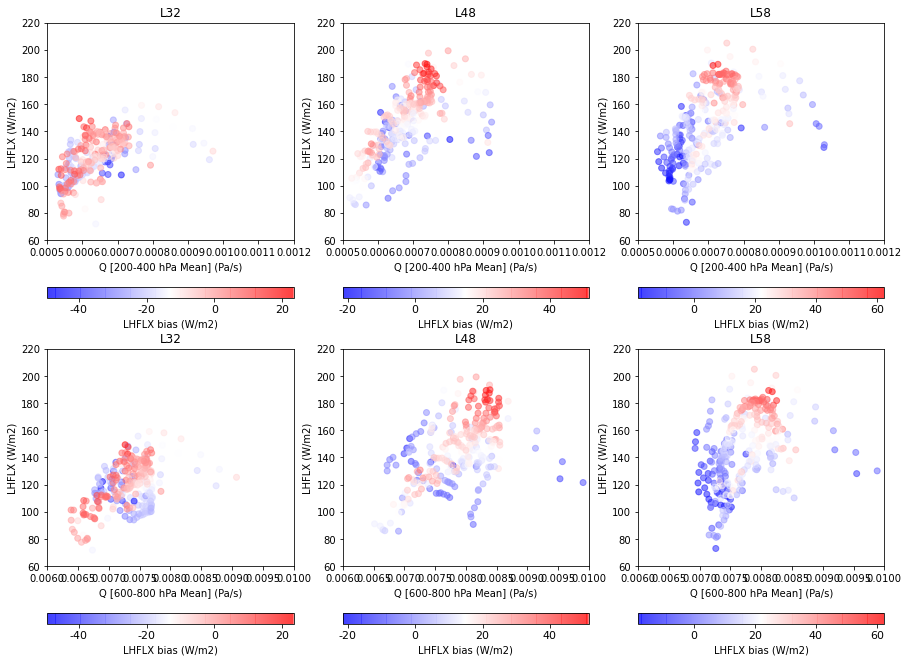

In [160]:
fig,axs = plt.subplots(2,3, figsize=(15,10) )
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

## Upper levels 

cplt = axs[0].scatter((upLev_L32.Q_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
               (upLev_L32.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(upLev_L32.lat.values)*len(upLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[0].set_title('L32')
axs[0].set_ylabel('LHFLX (W/m2)')
axs[0].set_xlabel('Q [200-400 hPa Mean] (Pa/s)')


cplt = axs[1].scatter((upLev_L48.Q_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
               (upLev_L48.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(upLev_L48.lat.values)*len(upLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[1].set_title('L48')
axs[1].set_ylabel('LHFLX (W/m2)')
axs[1].set_xlabel('Q [200-400 hPa Mean] (Pa/s)')


cplt = axs[2].scatter((upLev_L58.Q_interp.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
               (upLev_L58.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(upLev_L58.lat.values)*len(upLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[2].set_title('L58')
axs[2].set_ylabel('LHFLX (W/m2)')
axs[2].set_xlabel('Q [200-400 hPa Mean] (Pa/s)')

axs[0].set_ylim([60, 220])
axs[1].set_ylim([60, 220])
axs[2].set_ylim([60, 220])

axs[0].set_xlim([0.0005, 0.0012])
axs[1].set_xlim([0.0005, 0.0012])
axs[2].set_xlim([0.0005, 0.0012])



## Lower levels 

cplt = axs[3].scatter((lowLev_L32.Q_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
               (lowLev_L32.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            c = (LHbias_L32*regrid_mask['oceanMask'].values).reshape([len(lowLev_L32.lat.values)*len(lowLev_L32.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[3].set_title('L32')
axs[3].set_ylabel('LHFLX (W/m2)')
axs[3].set_xlabel('Q [600-800 hPa Mean] (Pa/s)')


cplt = axs[4].scatter((lowLev_L48.Q_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
               (lowLev_L48.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            c = (LHbias_L48*regrid_mask['oceanMask'].values).reshape([len(lowLev_L48.lat.values)*len(lowLev_L48.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[4].set_title('L48')
axs[4].set_ylabel('LHFLX (W/m2)')
axs[4].set_xlabel('Q [600-800 hPa Mean] (Pa/s)')


cplt = axs[5].scatter((lowLev_L58.Q_interp.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
               (lowLev_L58.LHFLX.values*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            c = (LHbias_L58*regrid_mask['oceanMask'].values).reshape([len(lowLev_L58.lat.values)*len(lowLev_L58.lon.values),1]),
            cmap ='bwr',alpha=0.5)
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='LHFLX bias (W/m2)', format='%.2g')
cbar.ax.tick_params(labelsize=11) 
axs[5].set_title('L58')
axs[5].set_ylabel('LHFLX (W/m2)')
axs[5].set_xlabel('Q [600-800 hPa Mean] (Pa/s)')

axs[3].set_ylim([60, 220])
axs[4].set_ylim([60, 220])
axs[5].set_ylim([60, 220])

axs[3].set_xlim([0.006, 0.01])
axs[4].set_xlim([0.006, 0.01])
axs[5].set_xlim([0.006, 0.01])



**Time-series?**

In [ ]:
## Select these points... 

## Get points that are already averaged in time too
IOpoint_L32     = L32_h1.sel(lon=92,lat=10, method='nearest').isel(time=np.where(L32_h1['time.year']>=2)[0])
IOpoint_L48     = L48_h1.sel(lon=92,lat=10, method='nearest').isel(time=np.where(L48_h1['time.year']>=2)[0])
IOpoint_L58     = L58_h1.sel(lon=92,lat=10, method='nearest').isel(time=np.where(L58_h1['time.year']>=2)[0])

SCSpointBot_L32 = L32_h1.sel(lon=112,lat=13, method='nearest').isel(time=np.where(L32_h1['time.year']>=2)[0])
SCSpointBot_L48 = L48_h1.sel(lon=112,lat=13, method='nearest').isel(time=np.where(L48_h1['time.year']>=2)[0])
SCSpointBot_L58 = L58_h1.sel(lon=112,lat=13, method='nearest').isel(time=np.where(L58_h1['time.year']>=2)[0])

WPpoint_L32     = L32_h1.sel(lon=135,lat=12, method='nearest').isel(time=np.where(L32_h1['time.year']>=2)[0])
WPpoint_L48     = L48_h1.sel(lon=135,lat=12, method='nearest').isel(time=np.where(L48_h1['time.year']>=2)[0])
WPpoint_L58     = L58_h1.sel(lon=135,lat=12, method='nearest').isel(time=np.where(L58_h1['time.year']>=2)[0])


In [ ]:
IOpoint_L32.lev.values

### Wind contours?

In [186]:
L32_h1['windSpeed'] = (('time','lev','lat','lon'), 
                       np.sqrt(L32_h1.U.values**2 + L32_h1.V.values**2))

L48_h1['windSpeed'] = (('time','lev','lat','lon'), 
                       np.sqrt(L48_h1.U.values**2 + L48_h1.V.values**2))

L58_h1['windSpeed'] = (('time','lev','lat','lon'), 
                       np.sqrt(L58_h1.U.values**2 + L58_h1.V.values**2))


In [187]:
## Get a few dates to look at the monsoon onset... 

# May 20 
L32_may20 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==5) & (L32_h1['time.day'].values==20) )[0])
L48_may20 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==5) & (L48_h1['time.day'].values==20) )[0])
L58_may20 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==5) & (L58_h1['time.day'].values==20) )[0])

# June 1 
L32_jun1 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==6) & (L32_h1['time.day'].values==1) )[0])
L48_jun1 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==6) & (L48_h1['time.day'].values==1) )[0])
L58_jun1 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==6) & (L58_h1['time.day'].values==1) )[0])

# June 10 
L32_jun10 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==6) & (L32_h1['time.day'].values==10) )[0])
L48_jun10 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==6) & (L48_h1['time.day'].values==10) )[0])
L58_jun10 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==6) & (L58_h1['time.day'].values==10) )[0])

# June 20
L32_jun20 = L32_h1.isel(time=np.where((L32_h1['time.month'].values==6) & (L32_h1['time.day'].values==20) )[0])
L48_jun20 = L48_h1.isel(time=np.where((L48_h1['time.month'].values==6) & (L48_h1['time.day'].values==20) )[0])
L58_jun20 = L58_h1.isel(time=np.where((L58_h1['time.month'].values==6) & (L58_h1['time.day'].values==20) )[0])



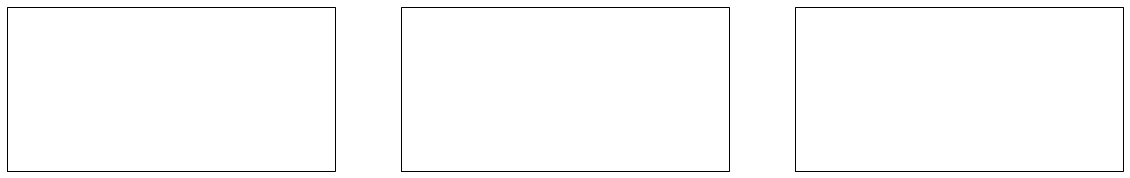

In [183]:
fig,axs = plt.subplots(1,3, figsize=(20, 4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

# plot velocity field
uvel, lonu = add_cyclic_point(L32_may20.U, coord=L32_may20.lon)
vvel, lonv = add_cyclic_point(L32_may20.V, coord=L32_may20.lon)
spd,  lons = add_cyclic_point(L32_may20, coord=L32_may20.lon)

lonu = np.where(lonu>=180.,lonu-360.,lonu)

strm=ax.streamplot(lonu, gustU.lat.values, 
                   uvel[levSel,:,:], vvel[levSel,:,:], 
                   density=5,
                   color=spd[levSel,:,:], 
                   cmap='autumn', 
                   transform=ccrs.PlateCarree())
cbar = fig.colorbar(strm.lines, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
cbar.set_label(gustU['U'].units,fontsize=14)

ax.set_title('Gust\nJJA-mean Streamlines at '+str(gustU.lev.values[levSel])+' hPa', fontsize=16)
ax.coastlines()



In [ ]:
###### fig = plt.figure(figsize=(20, 10))
ax  = plt.axes(projection=ccrs.PlateCarree())

levSel = 1

# plot velocity field
uvel, lonu = add_cyclic_point(gustU_meanJJA.U, coord=gustU_meanJJA.lon)
vvel, lonv = add_cyclic_point(gustV_meanJJA.V, coord=gustV_meanJJA.lon)
spd,  lons = add_cyclic_point(gustSpeed_meanJJA, coord=gustV_meanJJA.lon)

lonu = np.where(lonu>=180.,lonu-360.,lonu)

strm=ax.streamplot(lonu, gustU.lat.values, 
                   uvel[levSel,:,:], vvel[levSel,:,:], 
                   density=5,
                   color=spd[levSel,:,:], 
                   cmap='autumn', 
                   transform=ccrs.PlateCarree())
cbar = fig.colorbar(strm.lines, orientation='horizontal',pad=0.04, aspect=50, shrink=0.75)
cbar.set_label(gustU['U'].units,fontsize=14)

ax.set_title('Gust\nJJA-mean Streamlines at '+str(gustU.lev.values[levSel])+' hPa', fontsize=16)
ax.coastlines()

# ax.set_extent([50, 180, -20, 55], crs=ccrs.PlateCarree())